# Projet Traitement Large Échelle

Pour ce projet j'ai choisi d'utiliser RQLite comme base de données relationelle, et KeyDB comme base de données NoSQL.

Nous allons tout d'abord étudier KeyDB, en détaillant son fonctionnement, puis en effectuant des tests de performance.

Ensuite, nous ferons de même pour RQLite, et finalement nous comparerons les deux bases de données.

## Dataset

Nous allons utiliser le dataset : https://opendata.paris.fr/explore/dataset/stationnement-sur-voie-publique-stationnement-interdit/

Il contient les emplacements de stationnement interdit dans la ville de Paris.
Ci-dessous un exemple de donnée.

In [63]:
import json

import numpy as np
!pip install pandas


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd

file_path = 'data/stationnement-sur-voie-publique-stationnement-interdit.json'
df = pd.read_json(file_path)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22533 entries, 0 to 22532
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11126 non-null  float64
 1   id_old                  11407 non-null  object 
 2   regpri                  22533 non-null  object 
 3   regpar                  22533 non-null  object 
 4   arrond                  21021 non-null  float64
 5   zoneres                 21021 non-null  object 
 6   tar                     21021 non-null  object 
 7   typevoie                22533 non-null  object 
 8   nomvoie                 22533 non-null  object 
 9   parite                  22517 non-null  object 
 10  lon                     22533 non-null  float64
 11  longueur_calculee       22533 non-null  float64
 12  signhor                 22533 non-null  object 
 13  signvert                22533 non-null  object 
 14  confsign                22533 non-null

## Présentation de KeyDB

KeyDB est une version améliorée de Redis axée sur le multithreading, l'efficacité mémoire et le débit élevé.
Il conserve une compatibilité totale avec le protocole, les modules et les scripts Redis, tout en offrant des améliorations de performance telles que la réplication active et le stockage FLASH.

Grâce à son architecture MVCC, KeyDB permet l'exécution de requêtes telles que KEYS et SCAN sans bloquer la base de données ni dégrader les performances.
En utilisant le même matériel, KeyDB peut atteindre un débit significativement plus élevé que Redis.
 
Son architecture multithread simplifie la répartition des charges et permet une utilisation plus efficace des ressources matérielles. 
En outre, KeyDB offre une compatibilité avec les derniers développements de Redis, ce qui en fait un substitut direct pour les déploiements existants.

Sachant que KeyDB est un fork de redis, et qu'il est régulièrement synchronizé avec, il reste compatible avec tout les modules/extensions de Redis, nous parlerons donc de KeyDB/Redis.

KeyDB est généralement utilisé comme cache en raison de sa vitesse. Cependant, il peut faire bien plus grâce à ses modules. Ces extensions ajoutent des fonctionnalités comme la recherche en texte intégral, le traitement de données géospatiales, un moteur de recherche. Ainsi, bien qu'il soit souvent vu comme un simple cache, KeyDB peut s'adapter à une variété de cas d'utilisation grâce à ses modules, devenant ainsi une solution polyvalente pour divers besoins d'application.

Quelques avantages de KeyDB:

- Performances élevées : KeyDB offre des performances exceptionnelles grâce à son architecture multithreadée
- Compatibilité avec Redis : La compatibilité avec Redis permet aux utilisateurs de migrer facilement vers KeyDB sans nécessiter de modifications majeures du code
- Support de la communauté et des entreprises : Le projet est plutôt récent, mais bénéficie d'un soutien actif de la part de la communauté open-source ainsi que de certaines entreprises, assurant un développement continu et un support fiable.

Mais également quelques inconvénients

- Fonctionnalités limitées : Comparé à certains systèmes NoSQL plus établis, KeyDB peut manquer de certaines fonctionnalités avancées ou spécialisées, ce qui peut limiter son utilisation dans certains cas d'utilisation spécifiques.
- Documentation moins complète : Par rapport à des systèmes NoSQL plus populaires et matures, la documentation et les ressources d'apprentissage disponibles pour KeyDB peuvent être moins abondantes, ce qui peut poser des défis pour les nouveaux utilisateurs.
- Maturité relative : En tant que projet plutôt récent, KeyDB peut encore manquer de la stabilité et de la maturité des systèmes NoSQL plus établis, ce qui peut entraîner des problèmes potentiels de fiabilité ou de compatibilité.
- Dépendance aux threads : Bien que l'architecture multithreadée soit un avantage pour les performances, elle peut également introduire des complexités supplémentaires en matière de gestion des threads et de la concurrence dans le code, ce qui peut être un inconvénient pour certains développeurs.

### Installation et démarrage

Il est nécessaire d'avoir docker installé sur votre machine.

In [13]:
!docker run -p 6379:6379 --rm --name keydb-server -d eqalpha/keydb keydb-server /etc/keydb/keydb.conf --server-threads 4

86b59d6c9f90e47cf395da00224bb566fab1d7f2c853551e215b7674ebe26344


Nous allons commencer par faire des tests de performance pour des opérations de CRUD.

Pour celà, il suffit d'installer la librairie redis, puis de se connecter au serveur KeyDB.

In [14]:
!pip install redis


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import redis
import os
import platform
import time
import datetime
import math

In [16]:
# Connect to KeyDB
keydb_host = 'localhost'
keydb_port = 6379  # Default KeyDB port

# Create a connection to KeyDB
r = redis.Redis(host=keydb_host, port=keydb_port)

### Tests de performances

Toutes les mesures / serveurs tournent en local sur un PC qui contient:

In [17]:
system_info = platform.uname()

print("System Information:")
print(f"System: {system_info.system}")
print(f"Release: {system_info.release}")
print(f"Version: {system_info.version}")
print(f"Machine: {system_info.machine}")

System Information:
System: Windows
Release: 10
Version: 10.0.22631
Machine: AMD64


In [18]:
!grep -m 1 'model name' /proc/cpuinfo

'grep' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [19]:
first = df.head(1)

first_id_old = first.id_old.iloc[0]
print(first_id_old)

530001D20131119153127


#### Insertion d'un champ

In [20]:
structure = str(first.iloc[0])

start_time = time.time()
r.set(first_id_old, str(first.to_json()))
end_time = time.time()

time_taken_insertion = end_time - start_time
print("insertion time:", str(datetime.timedelta(seconds=time_taken_insertion)))

insertion time: 0:00:00.006859


#### Lecture d'un champ

In [21]:
start_time = time.time()
found = r.get(first_id_old)
end_time = time.time()

if found is not None:
    time_taken_read = end_time - start_time
    print("read time:", str(datetime.timedelta(seconds=time_taken_read)))
else:
    print("no row found")

read time: 0:00:00.002008


#### Mise à jour d'un champ déjà existant

KeyDB est une base de données clés/valeurs, donc il n'y a pas de "mise à jour" proprement dite, mais juste une réécriture.
Cependant, KeyDB/Redis possède un type de données hashset, qui permet de stocker une sorte de hashmap dans une clé, c'est ce qu'on pourra benchmark et comparer par la suite.

In [22]:
structure = str(first.iloc[0])

start_time = time.time()
r.set(first_id_old, str(first.to_json()) * 2)
end_time = time.time()

time_taken_update = end_time - start_time
print("update time:", str(datetime.timedelta(seconds=time_taken_update)))

update time: 0:00:00.001498


#### Suppression d'un champ

In [23]:
start_time = time.time()
deleted_ct = r.delete(first_id_old)
end_time = time.time()

if deleted_ct == 1:
    time_taken_deletion = end_time - start_time
    print("deletion time:", str(datetime.timedelta(seconds=time_taken_deletion)))
else:
    print("no row deleted")

deletion time: 0:00:00.001003


#### Quelques observations

On remarque que les temps sont extrêmement réduits, et que tout se passe en microsecondes.

#### Insertion du dataset complet

Il existe deux techniques, insertions l'une après l'autre des données ou l'insertion en masse.

L'insertion en masse est une technique nécessitant de suivre un protocole dédié à KeyDB.
Elle permet une insertion très rapide de beaucoup de données, car chaque SET unique est une opération à part entière et devient très vite, en cas d'un grand nombre de clés, une solution très lente et à éviter.

Nous n'allons pas étudier les résultats de l'insertion en masse, mais je vais vous présenter comment cela fonctionne.

Le protocole qu'il faut suivre se présente comme ci-dessous, prenons par exemple la commande <b>SET key value</b> :

```
*3<cr><lf>     <- On détermine d'abord le nombre d'arguments
$3<cr><lf>     <- Longueur de la commande
SET<cr><lf>    <- Commande SET
$3<cr><lf>     <- Longueur de la clé
key<cr><lf>    <- Valeur de la clé 
$5<cr><lf>     <- Longueur de valeur
value<cr><lf>  <- Valeur
```

Ainsi sur une ligne celà ressemblerait à :

`"*3\r\n$3\r\nSET\r\n$3\r\nkey\r\n$5\r\nvalue\r\n"`

Il suffit donc de faire un script qui transforme les données d'entrée en suivant ce protocole, puis :

`$ python conv.py data/stationnement-sur-voie-publique-stationnement-interdit.json | keydb-cli --pipe`

#### Insertion séquentielle complète du dataset

In [24]:
start_time = time.time()
total = 0
skipped = 0

for index, row in df.iterrows():
    id_old = row['id_old']
    if id_old is None:
        id_old = row['id']
    if id_old is None:
        skipped += 1
        continue
    structure = str(row.to_json())
    r.set(id_old, structure)
    total += 1

end_time = time.time()

time_taken_total_insertion = end_time - start_time
print("total dataset insertion time (success: %d/%d)" % (total, total + skipped),
      str(datetime.timedelta(seconds=time_taken_total_insertion)))

total dataset insertion time (success: 22533/22533) 0:00:25.234558


In [25]:
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [26]:
convert_size(os.path.getsize("data/stationnement-sur-voie-publique-stationnement-interdit.json"))

'25.07 MB'

On remarque que pour un dataset contenant <b>22533</b> clés et d'une grandeur totale de <b>25 MB</b>, on prend 6 secondes.

#### Test de performance de lecture en masse

Nous allons tester la lecture de toutes les clés, et mesurer le temps pris.

In [28]:
start_time = time.time()
total_found = 0
total_not_found = 0

for index, row in df.iterrows():
    id_old = row['id_old']
    if id_old is None:
        id_old = row['id']
    if id_old is None:
        total_not_found += 1
        continue

    structure = r.get(id_old)
    if structure is not None:
        total_found += 1
    else:
        total_not_found += 1

end_time = time.time()

time_taken_total_get = end_time - start_time
print("Total dataset retrieval time (found: %d, not found: %d)" % (total_found, total_not_found),
      str(datetime.timedelta(seconds=time_taken_total_get)))

Total dataset retrieval time (found: 10000, not found: 0) 0:00:09.402685


### À propos du partitionnement

Le partitionnement dans KeyDB divise les données entre plusieurs instances pour améliorer les performances et la capacité de stockage.
Pour se faire, deux méthodes principales sont utilisées : 

1) Le partitionnement par plage: il consiste à mapper des plages d'objets sur des instances spécifiques de KeyDB. Par exemple, on peut décider que les utilisateurs avec des identifiants de 0 à 10000 seront stockés dans l'instance R0, tandis que les utilisateurs avec des identifiants de 10001 à 20000 seront stockés dans l'instance R1, et ainsi de suite. Bien que ce système soit simple, il nécessite une table de correspondance des plages vers les instances, ce qui peut être inefficace à grande échelle.

2) Le partitionnement par hachage: il fonctionne avec n'importe quelle clé et est réalisé en deux étapes simples : d'abord, on applique une fonction de hachage à la clé pour obtenir un nombre, puis on effectue une opération modulo pour mapper ce nombre sur une instance spécifique de KeyDB. Par exemple, si la clé est "foobar" et que le résultat du hachage modulo 4 est 2, alors la clé "foobar" sera stockée dans l'instance R2 de KeyDB. Ce système est plus flexible et ne nécessite pas de table de correspondance.

### À propos des index

Comme KeyDB est une base de données clé-valeur, il n'y a pas d'index à proprement parler. Cependant, KeyDB permet de créer des index secondaires en utilisant ses structures de données avancées :

Ensembles triés (Sorted Sets) : Utilisés pour créer des index secondaires par ID ou autres champs numériques.
Ensembles triés avec plages lexicographiques : Pour des index secondaires plus avancés, y compris les index composites.
Ensembles (Sets) : Pour des index aléatoires.
Listes (Lists) : Pour des index simples itérables ou des index des derniers N éléments.
Ces mécanismes permettent de réaliser des requêtes complexes et d'optimiser les performances, bien que leur mise en œuvre puisse nécessiter une certaine expertise.

Nous ne ferons donc pas de tests de performance sur les index.

In [32]:
r.close()

In [86]:
!docker stop keydb-server

keydb-server


## Présentation de RQLite

RQLite est une base de données relationnelle qui combine la simplicité de SQLite avec la fiabilité d'un système distribué robuste. Il est facile à déployer et à utiliser. Basé sur SQLite, il assure le stockage fiable des données tout en offrant des fonctionnalités distribuées.

Quelques avantages:

- Léger et intégrable: rqlite est une base de données légère qui peut être facilement intégrée aux applications existantes.
- Distribué et tolérant aux pannes: rqlite réplique les données sur plusieurs nœuds, ce qui permet de maintenir la disponibilité des données même en cas de défaillance d'un nœud.
- Durable: rqlite prend en charge les transactions ACID, ce qui garantit l'intégrité des données.
- Scalable: rqlite peut être facilement mise à l'échelle horizontalement en ajoutant des nœuds supplémentaires au cluster.

### Installation et démarrage

Il est nécessaire d'avoir docker installé sur votre machine.

In [66]:
!docker run -p 4001:4001 --rm --name rqlite-server -d rqlite/rqlite --http-allow-origin="https://libsqlstudio.com"

8c12306a42c9c36abd8c447f0686bbc68964323b1549035f6968b897ed06676c


In [31]:
!pip install git+https://github.com/rqlite/pyrqlite.git

  Cloning https://github.com/rqlite/pyrqlite.git to c:\users\ipers\appdata\local\temp\pip-req-build-u3jvld7w
  Resolved https://github.com/rqlite/pyrqlite.git to commit 9f769bbe35a9a9ce7c099fdacf9caa0b4dba17ca
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pyrqlite: filename=pyrqlite-2.2.2-py3-none-any.whl size=14553 sha256=ba2833a9462ef9d3a0dfa6f38083176960be4bbecc5fa9fbdc53685f9ceaad6a
  Stored in directory: C:\Users\ipers\AppData\Local\Temp\pip-ephem-wheel-cache-oh3vz4sa\wheels\4a\9d\4e\3ab238c12f78d88009859af1b708538e273bdea54ce788df11
Successfully built pyrqlite


  Running command git clone --filter=blob:none --quiet https://github.com/rqlite/pyrqlite.git 'C:\Users\ipers\AppData\Local\Temp\pip-req-build-u3jvld7w'

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
import pyrqlite.dbapi2 as dbapi2

# Connect to the database
connection = dbapi2.connect(
    host='localhost',
    port=4001,
)

In [68]:
with connection.cursor() as cursor:
    cursor.execute("""CREATE TABLE IF NOT EXISTS test_table (
        id VARCHAR(255),
        regpri VARCHAR(255) NOT NULL,
        regpar VARCHAR(255) NOT NULL,
        arrond FLOAT,
        zoneres VARCHAR(255),
        tar VARCHAR(255),
        typevoie VARCHAR(255) NOT NULL,
        nomvoie VARCHAR(255) NOT NULL,
        parite VARCHAR(255),
        lon FLOAT NOT NULL,
        longueur_calculee FLOAT NOT NULL,
        signhor VARCHAR(255) NOT NULL,
        signvert VARCHAR(255) NOT NULL,
        confsign VARCHAR(255) NOT NULL,
        plage_hor1_debut VARCHAR(255),
        plage_hor1_fin VARCHAR(255),
        plage_hor2_debut VARCHAR(255),
        plage_hor2_fin VARCHAR(255),
        plage_hor3_debut VARCHAR(255),
        plage_hor3_fin VARCHAR(255),
        datereleve VARCHAR(255) NOT NULL,
        mtlast_edit_date_field VARCHAR(255) NOT NULL,
        c_voie_vp VARCHAR(255) NOT NULL,
        n_sq_tv INT NOT NULL,
        numilot FLOAT,
        numiris FLOAT,
        zoneasp VARCHAR(255),
        stv VARCHAR(255),
        prefet FLOAT,
        n_voieadd INT NOT NULL,
        n_voieadf INT NOT NULL,
        geo_shape VARCHAR(255) NOT NULL,
        geo_point_2d VARCHAR(255) NOT NULL,
        PRIMARY KEY (id)
    );""")

In [71]:
def get_id(row):
    result = row[0]
    if result is None or result != result:
        result = row[1]
    return result

def normalize(row):
    val = row.to_numpy()[0]
    val[0] = get_id(val)
    val = np.delete(val, 1)
    # geo_shape et geo_point_2d formattés en string
    val[31] = json.dumps(val[31])
    val[32] = json.dumps(val[32])
    
    for i in range(len(val)):
        if val[i] != val[i]:
            val[i] = 0
    return val

### Tests de performances

#### Insertion d'un champ


In [72]:
val = normalize(first)

start_time = time.time()
with connection.cursor() as cursor:
    cursor.execute("""INSERT INTO test_table (
            id, regpri, regpar, arrond, zoneres, tar, typevoie, nomvoie, parite, lon,
            longueur_calculee, signhor, signvert, confsign, plage_hor1_debut, plage_hor1_fin,
            plage_hor2_debut, plage_hor2_fin, plage_hor3_debut, plage_hor3_fin, datereleve,
            mtlast_edit_date_field, c_voie_vp, n_sq_tv, numilot, numiris, zoneasp, stv, prefet,
            n_voieadd, n_voieadf, geo_shape, geo_point_2d
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""", parameters=val)
    
end_time = time.time()
rqlite_insert_time = end_time - start_time
print("insertion time:", str(datetime.timedelta(seconds=rqlite_insert_time)))

{"error": "UNIQUE constraint failed: test_table.id"}


Error: {"error": "UNIQUE constraint failed: test_table.id"}

#### Lecture d'un champ

In [74]:
start_time = time.time()
with connection.cursor() as cursor:
    sql = "SELECT * FROM `test_table` WHERE `id`=:name"
    cursor.execute(sql, {'name': first_id_old})
    result = cursor.fetchone()
end_time = time.time()
rqlite_read_time = end_time - start_time
print("read time:", str(datetime.timedelta(seconds=rqlite_read_time)))
print(result)

read time: 0:00:00.003252
('530001D20131119153127', 'INTERDIT', 'Stationnement gênant', 8.0, '8F', '1', 'RUE', 'LAMENNAIS', 'Pair', 12.61749678, 12.61749678, 'Absente', 'Absente', 'SV Non-conforme', None, None, None, None, None, None, '2020-08-31', '2017-07-03', '5222', 750602357, 0.0, 0.0, '08Z2', 'STV Nord-Ouest', 0.0, 2, 14, '{"type": "Feature", "geometry": {"coordinates": [[2.302409241631641, 48.87439108342912], [2.302370429146084, 48.87442389454965], [2.3023661657542203, 48.87442796800206], [2.3023627545274232, 48.874432954755655], [2.30236019375872, 48.874438575105394], [2.302359336609679, 48.87444658414207], [2.302360185200712, 48.874452344873305], [2.30236358841582, 48.87445894968573], [2.302366993846696, 48.87446365869901], [2.302373805717524, 48.87446892986761], [2.302379767222101, 48.87447335699436], [2.302388286610417, 48.874476450914756], [2.3023959532251412, 48.87447898227307], [2.302402768808386, 48.87448010839671]], "type": "LineString"}, "properties": {}}', '{"lon": 2.

#### Mise à jour d'un champ déjà existant

In [77]:
val = normalize(first)
val = val[1:]
val = np.append(val, first_id_old)

start_time = time.time()
with connection.cursor() as cursor:
    cursor.execute("""UPDATE test_table SET 
        regpri=?, regpar=?, arrond=?, zoneres=?, tar=?, typevoie=?, nomvoie=?, parite=?, lon=?,
        longueur_calculee=?, signhor=?, signvert=?, confsign=?, plage_hor1_debut=?, plage_hor1_fin=?,
        plage_hor2_debut=?, plage_hor2_fin=?, plage_hor3_debut=?, plage_hor3_fin=?, datereleve=?,
        mtlast_edit_date_field=?, c_voie_vp=?, n_sq_tv=?, numilot=?, numiris=?, zoneasp=?, stv=?, prefet=?,
        n_voieadd=?, n_voieadf=?, geo_shape=?, geo_point_2d=?
        WHERE id=?
""", parameters=val)
end_time = time.time()
rqlite_update_time = end_time - start_time
print("update time:", str(datetime.timedelta(seconds=rqlite_update_time)))

update time: 0:00:00.050258


#### Suppression d'un champ

In [78]:
start_time = time.time()
with connection.cursor() as cursor:
    cursor.execute("DELETE FROM test_table WHERE id=?", (first_id_old,))
end_time = time.time()
rqlite_delete_time = end_time - start_time
print("deletion time:", str(datetime.timedelta(seconds=rqlite_delete_time)))

deletion time: 0:00:00.047867


#### Quelques observations

On remarque que les temps sont extrêmement réduits, et que tout se passe en microsecondes.

#### Insertion du dataset complet

In [82]:
start_time = time.time()
total = 0
skipped = 0
with connection.cursor() as cursor:
    
    # Send batch of 1000 rows
    batch = []
    
    for i in range(len(df)):
        val = normalize(df.iloc[[i]])
        batch.append(val)
        
        if len(batch) == 1000:
            cursor.executemany("""INSERT INTO test_table (
                    id, regpri, regpar, arrond, zoneres, tar, typevoie, nomvoie, parite, lon,
                    longueur_calculee, signhor, signvert, confsign, plage_hor1_debut, plage_hor1_fin,
                    plage_hor2_debut, plage_hor2_fin, plage_hor3_debut, plage_hor3_fin, datereleve,
                    mtlast_edit_date_field, c_voie_vp, n_sq_tv, numilot, numiris, zoneasp, stv, prefet,
                    n_voieadd, n_voieadf, geo_shape, geo_point_2d
                ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, seq_of_parameters=batch)
            batch = []
            total += 1000
    if len(batch) > 0:
        cursor.executemany("""INSERT INTO test_table (
        id, regpri, regpar, arrond, zoneres, tar, typevoie, nomvoie, parite, lon,
        longueur_calculee, signhor, signvert, confsign, plage_hor1_debut, plage_hor1_fin,
        plage_hor2_debut, plage_hor2_fin, plage_hor3_debut, plage_hor3_fin, datereleve,
        mtlast_edit_date_field, c_voie_vp, n_sq_tv, numilot, numiris, zoneasp, stv, prefet,
        n_voieadd, n_voieadf, geo_shape, geo_point_2d
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, seq_of_parameters=batch)
        
        total += len(batch)
end_time = time.time()
rqlite_total_insert_time = end_time - start_time
print("total dataset insertion time (success: %d/%d)" % (total, total + skipped),
      str(datetime.timedelta(seconds=rqlite_total_insert_time)))

total dataset insertion time (success: 22533/22533) 0:00:08.802515


#### Test de performance de lecture en masse

In [83]:
start_time = time.time()
total_found = 0
total_not_found = 0
with connection.cursor() as cursor:
    for i in range(len(df)):
        val = normalize(df.iloc[[i]])
        cursor.execute("SELECT * FROM `test_table` WHERE `id`=?", (val[0],))
        result = cursor.fetchone()
        if result is not None:
            total_found += 1
        else:
            total_not_found += 1
end_time = time.time()
rqlite_total_get_time = end_time - start_time
print("Total dataset retrieval time (found: %d, not found: %d)" % (total_found, total_not_found),
      str(datetime.timedelta(seconds=rqlite_total_get_time)))

Total dataset retrieval time (found: 22533, not found: 0) 0:00:40.007900


In [84]:
connection.close()

In [85]:
!docker stop rqlite-server

rqlite-server


## Comparaison des deux bases de données

Nous allons comparer les performances des deux bases de données en fonction des opérations CRUD.

Avec matplotlib, nous allons afficher les temps pris pour chaque opération.

In [87]:
!pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/b9/55/6138ad64c789bad13d18e0240da75e73dbd364fdc0aa670fff87a5eef5ab/matplotlib-3.9.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/b6/b2/27c7a0d46c7dceb9083272eb314bef1ed43e5280a4197719656f866b496d/contourpy-1.2.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/eb/6f/27897f57a4163bade97e26687a1369c191d80b6acb448025e27c8956e4f0/fonttools-4.51.0-cp310-cp310-win_amd64.whl.metadata
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


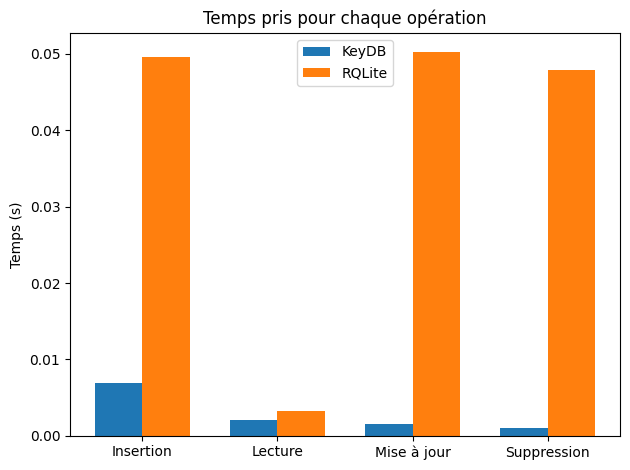

In [88]:
import matplotlib.pyplot as plt

# Data
labels = ['Insertion', 'Lecture', 'Mise à jour', 'Suppression']
keydb_times = [time_taken_insertion, time_taken_read, time_taken_update, time_taken_deletion]
rqlite_times = [rqlite_insert_time, rqlite_read_time, rqlite_update_time, rqlite_delete_time]

# Plot
fig, ax = plt.subplots()
bar_width = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x - bar_width/2, keydb_times, bar_width, label='KeyDB')

rects2 = ax.bar(x + bar_width/2, rqlite_times, bar_width, label='RQLite')

ax.set_ylabel('Temps (s)')
ax.set_title('Temps pris pour chaque opération')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

### Observations

On remarque que KeyDB est plus rapide que RQLite pour toutes les opérations CRUD.

En effet, KeyDB est une base de données clé-valeur, ce qui lui permet d'être plus rapide que RQLite, qui est une base de données relationnelle.

Nous allons maintenant comparer les temps pris pour l'insertion de tout le dataset et la lecture de toutes les clés.

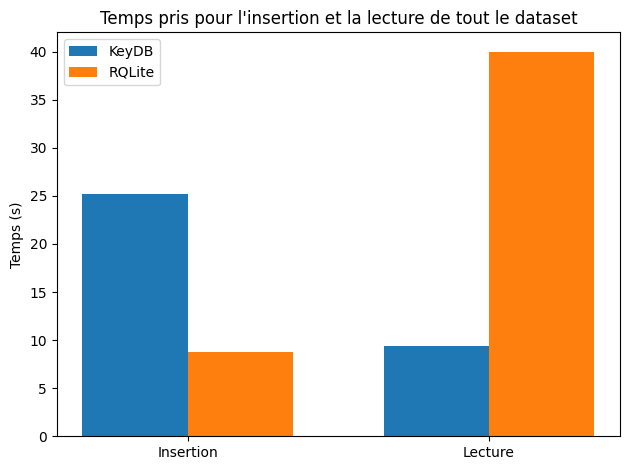

In [89]:
# Data
labels = ['Insertion', 'Lecture']
keydb_times = [time_taken_total_insertion, time_taken_total_get]
rqlite_times = [rqlite_total_insert_time, rqlite_total_get_time]

# Plot
fig, ax = plt.subplots()
bar_width = 0.35
x = np.arange(len(labels))
rects1 = ax.bar(x - bar_width/2, keydb_times, bar_width, label='KeyDB')

rects2 = ax.bar(x + bar_width/2, rqlite_times, bar_width, label='RQLite')

ax.set_ylabel('Temps (s)')
ax.set_title('Temps pris pour l\'insertion et la lecture de tout le dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

### Observations

On remarque que RQLite est plus rapide que KeyDB pour l'insertion de tout le dataset, mais que KeyDB est plus rapide pour la lecture de toutes les clés.

Ceci est dû au fait qu'on a inséré les données dans RQLite en batch, contrairement à KeyDB où on a inséré les données une par une.

## Conclusion

KeyDB est une base de données clé-valeur rapide et performante, tandis que RQLite est une base de données relationnelle distribuée et tolérante aux pannes.

KeyDB est plus rapide que RQLite pour les opérations CRUD, mais cela dépend du type de données et de l'opération effectuée.

RQLite permet de faire des requêtes SQL, ce qui est plus pratique pour des données relationnelles, tandis que KeyDB est plus adapté pour des données clé-valeur.

En conclusion, le choix entre KeyDB et RQLite dépend du type de données et des opérations que vous souhaitez effectuer.